# BERT Fine-tuning on ALL GLUE Tasks (Automated)

This notebook automatically trains, evaluates, and generates predictions for **ALL GLUE benchmark tasks**.

## Features:
- **Automatic training** of all 9 GLUE tasks in sequence
- **Training curves** visualization for each task
- **Model saving** after each task
- **Final submission ZIP** generation for GLUE leaderboard

## GLUE Tasks:
- CoLA, SST-2, MRPC, STS-B, QQP, MNLI, QNLI, RTE, WNLI, AX

**Just run all cells from top to bottom!**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/553-main')

!ls

Mounted at /content/drive
bert_classifier.py	  MRPC.tsv
bert_model_glue_cola.pth  plot.py
bert_model_glue_mrpc.pth  preprocess
bert_model_glue_qnli.pth  __pycache__
bert_model_glue_qqp.pth   QNLI.tsv
bert_model_glue_rte.pth   QQP.tsv
bert_model_glue_sst2.pth  README.md
bert_model_glue_stsb.pth  requirements.txt
bert_model_glue_wnli.pth  RTE.tsv
CoLA.tsv		  sst2_submission.tsv
finetune.py		  sst2_submission.zip
glue_finetune_all.ipynb   SST-2.tsv
glue_finetune.ipynb	  STS-B.tsv
glue_results.json	  test.py
GLUE_submission.zip	  tokenizer.py
glue_training_curves.png  training_history_glue_sst2.json
lr.png			  wikitext-2_wordpiece.json
lr_svm.py		  WNLI.tsv


In [2]:
# Cell 1: Import libraries and setup
import sys
import os
sys.path.append('553-main')

import dataclasses
import functools
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import csv
import zipfile
import json
from datetime import datetime
from datasets import load_dataset
from transformers import BertTokenizer, BertModel as HFBertModel
from torch import Tensor
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from scipy.stats import pearsonr, spearmanr

# From finetune.py
from finetune import (
    BertConfig,
    BertModel,
    BertForSequenceClassification,
    load_pretrained_into_custom_bert
)

print("="*60)
print("GLUE Benchmark - Automated Training Pipeline")
print("="*60)
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
print("="*60)


GLUE Benchmark - Automated Training Pipeline
PyTorch Version: 2.9.0+cu126
CUDA Available: True
CUDA Device: NVIDIA L4


In [3]:
# Cell 2: Configuration

# All GLUE Tasks Configuration
GLUE_TASKS = {
    "cola": {"name": "CoLA", "metric": "matthews_correlation", "is_pair": False, "is_regression": False, "num_labels": 2},
    "sst2": {"name": "SST-2", "metric": "accuracy", "is_pair": False, "is_regression": False, "num_labels": 2},
    "mrpc": {"name": "MRPC", "metric": "f1", "is_pair": True, "is_regression": False, "num_labels": 2},
    "stsb": {"name": "STS-B", "metric": "pearson_spearman", "is_pair": True, "is_regression": True, "num_labels": 1},
    "qqp": {"name": "QQP", "metric": "f1", "is_pair": True, "is_regression": False, "num_labels": 2},
    "mnli": {"name": "MNLI", "metric": "accuracy", "is_pair": True, "is_regression": False, "num_labels": 3},
    "qnli": {"name": "QNLI", "metric": "accuracy", "is_pair": True, "is_regression": False, "num_labels": 2},
    "rte": {"name": "RTE", "metric": "accuracy", "is_pair": True, "is_regression": False, "num_labels": 2},
    "wnli": {"name": "WNLI", "metric": "accuracy", "is_pair": True, "is_regression": False, "num_labels": 2},
}

# Training Configuration
TRAIN_CONFIG = {
    "batch_size": 16,
    "max_len": 128,
    "learning_rate": 2e-5,
    "num_epochs": 3,
    "weight_decay": 0.01
}

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")
print(f"Tasks to train: {list(GLUE_TASKS.keys())}")
print(f"Total tasks: {len(GLUE_TASKS)}")


Using Device: cuda
Tasks to train: ['cola', 'sst2', 'mrpc', 'stsb', 'qqp', 'mnli', 'qnli', 'rte', 'wnli']
Total tasks: 9


In [4]:
# Cell 3: Model Classes and Helper Functions

class BertForSequenceClassificationPair(nn.Module):
    """BERT model for sentence pair classification"""
    def __init__(self, config: BertConfig, num_labels: int):
        super().__init__()
        self.bert = BertModel(config)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(self, input_ids: Tensor, token_type_ids: Tensor = None, pad_id=0):
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        _, pooled_output = self.bert(input_ids, token_type_ids, pad_id=pad_id)
        return self.classifier(pooled_output)

class BertForSequenceRegressionPair(nn.Module):
    """BERT model for sentence pair regression (STS-B)"""
    def __init__(self, config: BertConfig):
        super().__init__()
        self.bert = BertModel(config)
        self.regressor = nn.Linear(config.hidden_size, 1)

    def forward(self, input_ids: Tensor, token_type_ids: Tensor = None, pad_id=0):
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        _, pooled_output = self.bert(input_ids, token_type_ids, pad_id=pad_id)
        return self.regressor(pooled_output)

# Data Collate Functions
def collate_glue_single(batch, tokenizer, max_len, is_regression=False):
    texts = [x["sentence"] if "sentence" in x else x["text"] for x in batch]
    label_dtype = torch.float if is_regression else torch.long
    labels = torch.tensor([x["label"] for x in batch], dtype=label_dtype)
    encoded = tokenizer(texts, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt", add_special_tokens=True)
    return encoded["input_ids"], labels

def collate_glue_pair(batch, tokenizer, max_len, is_regression=False):
    if "sentence1" in batch[0] and "sentence2" in batch[0]:
        texts = [(x["sentence1"], x["sentence2"]) for x in batch]
    elif "premise" in batch[0] and "hypothesis" in batch[0]:
        texts = [(x["premise"], x["hypothesis"]) for x in batch]
    elif "question" in batch[0] and "sentence" in batch[0]:
        texts = [(x["question"], x["sentence"]) for x in batch]
    elif "question1" in batch[0] and "question2" in batch[0]:
        texts = [(x["question1"], x["question2"]) for x in batch]
    else:
        raise ValueError(f"Unknown format: {batch[0].keys()}")

    label_dtype = torch.float if is_regression else torch.long
    labels = torch.tensor([x["label"] for x in batch], dtype=label_dtype)
    encoded = tokenizer(texts, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt", add_special_tokens=True)
    return encoded["input_ids"], encoded["token_type_ids"], labels

def collate_test(batch, tokenizer, max_len, is_pair=False):
    if is_pair:
        if "sentence1" in batch[0] and "sentence2" in batch[0]:
            texts = [(x["sentence1"], x["sentence2"]) for x in batch]
        elif "premise" in batch[0] and "hypothesis" in batch[0]:
            texts = [(x["premise"], x["hypothesis"]) for x in batch]
        elif "question" in batch[0] and "sentence" in batch[0]:
            texts = [(x["question"], x["sentence"]) for x in batch]
        elif "question1" in batch[0] and "question2" in batch[0]:
            texts = [(x["question1"], x["question2"]) for x in batch]
        else:
            raise ValueError(f"Unknown format: {batch[0].keys()}")
        encoded = tokenizer(texts, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt", add_special_tokens=True)
        return encoded["input_ids"], encoded["token_type_ids"]
    else:
        texts = [x["sentence"] if "sentence" in x else x["text"] for x in batch]
        encoded = tokenizer(texts, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt", add_special_tokens=True)
        return encoded["input_ids"]

def evaluate_model(model, val_loader, task_config, device, pad_id):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    loss_fn = nn.MSELoss() if task_config['is_regression'] else nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in val_loader:
            if task_config['is_pair']:
                input_ids, token_type_ids, labels = batch
                input_ids, token_type_ids, labels = input_ids.to(device), token_type_ids.to(device), labels.to(device)
                outputs = model(input_ids, token_type_ids, pad_id=pad_id)
            else:
                input_ids, labels = batch
                input_ids, labels = input_ids.to(device), labels.to(device)
                outputs = model(input_ids, pad_id=pad_id)

            if task_config['is_regression']:
                outputs = outputs.squeeze(-1) if outputs.dim() > 1 else outputs
                loss = loss_fn(outputs, labels)
                preds = outputs.cpu().numpy()
            else:
                loss = loss_fn(outputs, labels)
                preds = outputs.argmax(dim=-1).cpu().numpy()

            total_loss += loss.item()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)

    if task_config['is_regression']:
        pearson_corr, _ = pearsonr(all_labels, all_preds)
        spearman_corr, _ = spearmanr(all_labels, all_preds)
        return {'pearson': pearson_corr, 'spearman': spearman_corr, 'pearson_spearman': (pearson_corr + spearman_corr) / 2, 'loss': avg_loss}
    else:
        return {'accuracy': accuracy_score(all_labels, all_preds), 'f1': f1_score(all_labels, all_preds, average='weighted'), 'mcc': matthews_corrcoef(all_labels, all_preds), 'loss': avg_loss}

print("Model classes and helper functions defined!")


Model classes and helper functions defined!


In [5]:
# Cell 4: Main Training Function

def train_single_task(task_key, task_config, device, tokenizer, pad_id, pretrained_state):
    """Train a single GLUE task and return training history"""
    print(f"\n{'='*60}")
    print(f"Training: {task_config['name']} ({task_key})")
    print(f"{'='*60}")

    # Load dataset
    print(f"Loading {task_key} dataset...")
    dataset = load_dataset("glue", task_key)
    print(f"  Train: {len(dataset['train'])}, Validation: {len(dataset['validation'])}")

    # Create model
    config = BertConfig()
    if task_config['is_regression']:
        model = BertForSequenceRegressionPair(config).to(device)
    elif task_config['is_pair']:
        model = BertForSequenceClassificationPair(config, task_config['num_labels']).to(device)
    else:
        model = BertForSequenceClassification(config, task_config['num_labels']).to(device)

    # Load pretrained weights
    load_pretrained_into_custom_bert(model.bert, pretrained_state)

    # Create data loaders
    if task_config['is_pair']:
        collate_fn = functools.partial(collate_glue_pair, tokenizer=tokenizer, max_len=TRAIN_CONFIG['max_len'], is_regression=task_config['is_regression'])
    else:
        collate_fn = functools.partial(collate_glue_single, tokenizer=tokenizer, max_len=TRAIN_CONFIG['max_len'], is_regression=task_config['is_regression'])

    train_loader = torch.utils.data.DataLoader(dataset['train'], batch_size=TRAIN_CONFIG['batch_size'], shuffle=True, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(dataset['validation'], batch_size=TRAIN_CONFIG['batch_size'], shuffle=False, collate_fn=collate_fn)

    # Training setup
    loss_fn = nn.MSELoss() if task_config['is_regression'] else nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=TRAIN_CONFIG['learning_rate'], weight_decay=TRAIN_CONFIG['weight_decay'])

    history = {'train_loss': [], 'val_loss': [], 'val_metric': [], 'metric_name': task_config['metric']}

    # Training loop
    for epoch in range(TRAIN_CONFIG['num_epochs']):
        model.train()
        train_loss = 0

        for batch in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{TRAIN_CONFIG['num_epochs']}"):
            if task_config['is_pair']:
                input_ids, token_type_ids, labels = batch
                input_ids, token_type_ids, labels = input_ids.to(device), token_type_ids.to(device), labels.to(device)
                outputs = model(input_ids, token_type_ids, pad_id=pad_id)
            else:
                input_ids, labels = batch
                input_ids, labels = input_ids.to(device), labels.to(device)
                outputs = model(input_ids, pad_id=pad_id)

            if task_config['is_regression']:
                outputs = outputs.squeeze(-1) if outputs.dim() > 1 else outputs

            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        val_metrics = evaluate_model(model, val_loader, task_config, device, pad_id)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_metrics['loss'])

        if task_config['is_regression']:
            history['val_metric'].append(val_metrics['pearson_spearman'])
            print(f"  Epoch {epoch+1}: Loss={avg_train_loss:.4f}, Pearson={val_metrics['pearson']:.4f}, Spearman={val_metrics['spearman']:.4f}")
        elif task_config['metric'] == 'matthews_correlation':
            history['val_metric'].append(val_metrics['mcc'])
            print(f"  Epoch {epoch+1}: Loss={avg_train_loss:.4f}, MCC={val_metrics['mcc']:.4f}")
        elif task_config['metric'] == 'f1':
            history['val_metric'].append(val_metrics['f1'])
            print(f"  Epoch {epoch+1}: Loss={avg_train_loss:.4f}, F1={val_metrics['f1']:.4f}")
        else:
            history['val_metric'].append(val_metrics['accuracy'])
            print(f"  Epoch {epoch+1}: Loss={avg_train_loss:.4f}, Acc={val_metrics['accuracy']:.4f}")

    # Save model
    model_path = f"bert_model_glue_{task_key}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"  Model saved: {model_path}")

    return model, history, dataset

print("Training function defined!")


Training function defined!


In [6]:
# Cell 5: Train ALL GLUE Tasks

# Load tokenizer and pretrained weights (only once)
print("Loading tokenizer and pretrained BERT weights...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
pad_id = tokenizer.pad_token_id
hf_bert = HFBertModel.from_pretrained("bert-base-uncased")
pretrained_state = hf_bert.state_dict()
print("Done!")

# Store results for all tasks
all_results = {}
all_histories = {}
all_models = {}
all_datasets = {}

# Train each task
start_time = datetime.now()
print(f"\nStarting training at {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training {len(GLUE_TASKS)} tasks...\n")

for task_key, task_config in GLUE_TASKS.items():
    try:
        model, history, dataset = train_single_task(task_key, task_config, device, tokenizer, pad_id, pretrained_state)
        all_models[task_key] = model
        all_histories[task_key] = history
        all_datasets[task_key] = dataset
        all_results[task_key] = {
            'best_metric': max(history['val_metric']),
            'metric_name': history['metric_name'],
            'final_loss': history['val_loss'][-1]
        }
    except Exception as e:
        print(f"Error training {task_key}: {e}")
        import traceback
        traceback.print_exc()

end_time = datetime.now()
print(f"\n{'='*60}")
print(f"Training completed at {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total time: {end_time - start_time}")
print(f"{'='*60}")


Loading tokenizer and pretrained BERT weights...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Done!

Starting training at 2025-12-07 07:57:26
Training 9 tasks...


Training: CoLA (cola)
Loading cola dataset...
  Train: 8551, Validation: 1043
Loaded HuggingFace BERT weights!


Epoch 1/3: 100%|██████████| 535/535 [01:33<00:00,  5.70it/s]


  Epoch 1: Loss=0.4663, MCC=0.5235


Epoch 2/3: 100%|██████████| 535/535 [01:33<00:00,  5.72it/s]


  Epoch 2: Loss=0.2503, MCC=0.5573


Epoch 3/3: 100%|██████████| 535/535 [01:33<00:00,  5.73it/s]


  Epoch 3: Loss=0.1299, MCC=0.5713
  Model saved: bert_model_glue_cola.pth

Training: SST-2 (sst2)
Loading sst2 dataset...
  Train: 67349, Validation: 872
Loaded HuggingFace BERT weights!


Epoch 1/3: 100%|██████████| 4210/4210 [12:17<00:00,  5.71it/s]


  Epoch 1: Loss=0.1960, Acc=0.9163


Epoch 2/3: 100%|██████████| 4210/4210 [12:17<00:00,  5.71it/s]


  Epoch 2: Loss=0.1031, Acc=0.9083


Epoch 3/3: 100%|██████████| 4210/4210 [12:17<00:00,  5.71it/s]


  Epoch 3: Loss=0.0658, Acc=0.9220
  Model saved: bert_model_glue_sst2.pth

Training: MRPC (mrpc)
Loading mrpc dataset...
  Train: 3668, Validation: 408
Loaded HuggingFace BERT weights!


Epoch 1/3: 100%|██████████| 230/230 [00:42<00:00,  5.42it/s]


  Epoch 1: Loss=0.5383, F1=0.8373


Epoch 2/3: 100%|██████████| 230/230 [00:42<00:00,  5.44it/s]


  Epoch 2: Loss=0.2936, F1=0.8749


Epoch 3/3: 100%|██████████| 230/230 [00:42<00:00,  5.43it/s]


  Epoch 3: Loss=0.1219, F1=0.8566
  Model saved: bert_model_glue_mrpc.pth

Training: STS-B (stsb)
Loading stsb dataset...


stsb/train-00000-of-00001.parquet:   0%|          | 0.00/502k [00:00<?, ?B/s]

stsb/validation-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

stsb/test-00000-of-00001.parquet:   0%|          | 0.00/114k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

  Train: 5749, Validation: 1500
Loaded HuggingFace BERT weights!


Epoch 1/3: 100%|██████████| 360/360 [01:04<00:00,  5.56it/s]


  Epoch 1: Loss=1.0359, Pearson=0.8832, Spearman=0.8797


Epoch 2/3: 100%|██████████| 360/360 [01:04<00:00,  5.60it/s]


  Epoch 2: Loss=0.3664, Pearson=0.8963, Spearman=0.8919


Epoch 3/3: 100%|██████████| 360/360 [01:04<00:00,  5.59it/s]


  Epoch 3: Loss=0.2053, Pearson=0.8962, Spearman=0.8938
  Model saved: bert_model_glue_stsb.pth

Training: QQP (qqp)
Loading qqp dataset...
  Train: 363846, Validation: 40430
Loaded HuggingFace BERT weights!


Epoch 1/3: 100%|██████████| 22741/22741 [1:08:10<00:00,  5.56it/s]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens 

  Epoch 1: Loss=0.2862, F1=0.8976


Epoch 2/3: 100%|██████████| 22741/22741 [1:08:10<00:00,  5.56it/s]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens 

  Epoch 2: Loss=0.1813, F1=0.9081


Epoch 3/3: 100%|██████████| 22741/22741 [1:08:10<00:00,  5.56it/s]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens 

  Epoch 3: Loss=0.1185, F1=0.9092
  Model saved: bert_model_glue_qqp.pth

Training: MNLI (mnli)
Loading mnli dataset...


mnli/train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

mnli/validation_matched-00000-of-00001.p(…):   0%|          | 0.00/1.21M [00:00<?, ?B/s]

mnli/validation_mismatched-00000-of-0000(…):   0%|          | 0.00/1.25M [00:00<?, ?B/s]

mnli/test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

mnli/test_mismatched-00000-of-00001.parq(…):   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Error training mnli: 'validation'

Training: QNLI (qnli)
Loading qnli dataset...


Traceback (most recent call last):
  File "/tmp/ipython-input-1148307234.py", line 24, in <cell line: 0>
    model, history, dataset = train_single_task(task_key, task_config, device, tokenizer, pad_id, pretrained_state)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-710483594.py", line 12, in train_single_task
    print(f"  Train: {len(dataset['train'])}, Validation: {len(dataset['validation'])}")
                                                               ~~~~~~~^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/datasets/dataset_dict.py", line 82, in __getitem__
    return super().__getitem__(k)
           ^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'validation'


qnli/train-00000-of-00001.parquet:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

qnli/validation-00000-of-00001.parquet:   0%|          | 0.00/872k [00:00<?, ?B/s]

qnli/test-00000-of-00001.parquet:   0%|          | 0.00/877k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/104743 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5463 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5463 [00:00<?, ? examples/s]

  Train: 104743, Validation: 5463
Loaded HuggingFace BERT weights!


Epoch 1/3:   1%|▏         | 82/6547 [00:15<19:59,  5.39it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1/3:  16%|█▌        | 1046/6547 [03:13<16:56,  5.41it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some 

  Epoch 1: Loss=0.3201, Acc=0.9041


Epoch 2/3:   2%|▏         | 148/6547 [00:27<19:29,  5.47it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 2/3:  14%|█▍        | 917/6547 [02:49<17:13,  5.45it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some 

  Epoch 2: Loss=0.1732, Acc=0.9061


Epoch 3/3:  38%|███▊      | 2465/6547 [07:35<12:32,  5.43it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 3/3:  52%|█████▏    | 3381/6547 [10:24<09:46,  5.40it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if som

  Epoch 3: Loss=0.0850, Acc=0.9076
  Model saved: bert_model_glue_qnli.pth

Training: RTE (rte)
Loading rte dataset...


rte/train-00000-of-00001.parquet:   0%|          | 0.00/584k [00:00<?, ?B/s]

rte/validation-00000-of-00001.parquet:   0%|          | 0.00/69.0k [00:00<?, ?B/s]

rte/test-00000-of-00001.parquet:   0%|          | 0.00/621k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

  Train: 2490, Validation: 277
Loaded HuggingFace BERT weights!


Epoch 1/3:   0%|          | 0/156 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1/3:   1%|          | 1/156 [00:00<00:30,  5.09it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have be

  Epoch 1: Loss=0.6577, Acc=0.6498


Epoch 2/3:   0%|          | 0/156 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 2/3:   1%|▏         | 2/156 [00:00<00:29

  Epoch 2: Loss=0.4500, Acc=0.7112


Epoch 3/3:   1%|          | 1/156 [00:00<00:29,  5.29it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 3/3:   2%|▏         | 3/156 [00:

  Epoch 3: Loss=0.2097, Acc=0.6895
  Model saved: bert_model_glue_rte.pth

Training: WNLI (wnli)
Loading wnli dataset...


wnli/train-00000-of-00001.parquet:   0%|          | 0.00/38.8k [00:00<?, ?B/s]

wnli/validation-00000-of-00001.parquet:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

wnli/test-00000-of-00001.parquet:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/635 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/71 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/146 [00:00<?, ? examples/s]

  Train: 635, Validation: 71
Loaded HuggingFace BERT weights!


Epoch 1/3: 100%|██████████| 40/40 [00:07<00:00,  5.61it/s]


  Epoch 1: Loss=0.7144, Acc=0.4366


Epoch 2/3: 100%|██████████| 40/40 [00:07<00:00,  5.58it/s]


  Epoch 2: Loss=0.6953, Acc=0.4930


Epoch 3/3: 100%|██████████| 40/40 [00:07<00:00,  5.55it/s]


  Epoch 3: Loss=0.6939, Acc=0.5493
  Model saved: bert_model_glue_wnli.pth

Training completed at 2025-12-07 13:21:34
Total time: 5:24:08.073769


In [6]:
# Cell 5.1: Train MNLI Only (Run this if MNLI training failed)
# This cell can be run independently after running Cells 1-4

print("="*60)
print("TRAINING MNLI ONLY")
print("="*60)

# Load tokenizer and pretrained weights if not already loaded
if 'tokenizer' not in dir() or tokenizer is None:
    print("Loading tokenizer and pretrained BERT weights...")
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    pad_id = tokenizer.pad_token_id
    hf_bert = HFBertModel.from_pretrained("bert-base-uncased")
    pretrained_state = hf_bert.state_dict()
    print("Done!")

# Initialize storage if not exists
if 'all_models' not in dir():
    all_models = {}
if 'all_histories' not in dir():
    all_histories = {}
if 'all_datasets' not in dir():
    all_datasets = {}
if 'all_results' not in dir():
    all_results = {}

# MNLI task config
task_key = "mnli"
task_config = GLUE_TASKS[task_key]

print(f"\n{'='*60}")
print(f"Training: {task_config['name']} ({task_key})")
print(f"{'='*60}")

# Load MNLI dataset
print(f"Loading {task_key} dataset...")
mnli_dataset = load_dataset("glue", task_key)
print(f"  Train: {len(mnli_dataset['train'])}")
print(f"  Validation (matched): {len(mnli_dataset['validation_matched'])}")
print(f"  Validation (mismatched): {len(mnli_dataset['validation_mismatched'])}")
print(f"  Test (matched): {len(mnli_dataset['test_matched'])}")
print(f"  Test (mismatched): {len(mnli_dataset['test_mismatched'])}")

# Create model
config = BertConfig()
mnli_model = BertForSequenceClassificationPair(config, task_config['num_labels']).to(device)

# Load pretrained weights
load_pretrained_into_custom_bert(mnli_model.bert, pretrained_state)

# Create data loaders
collate_fn = functools.partial(collate_glue_pair, tokenizer=tokenizer, max_len=TRAIN_CONFIG['max_len'], is_regression=False)
train_loader = torch.utils.data.DataLoader(mnli_dataset['train'], batch_size=TRAIN_CONFIG['batch_size'], shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(mnli_dataset['validation_matched'], batch_size=TRAIN_CONFIG['batch_size'], shuffle=False, collate_fn=collate_fn)

# Training setup
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(mnli_model.parameters(), lr=TRAIN_CONFIG['learning_rate'], weight_decay=TRAIN_CONFIG['weight_decay'])

mnli_history = {'train_loss': [], 'val_loss': [], 'val_metric': [], 'metric_name': 'accuracy'}

# Training loop
for epoch in range(TRAIN_CONFIG['num_epochs']):
    mnli_model.train()
    train_loss = 0

    for batch in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{TRAIN_CONFIG['num_epochs']}"):
        input_ids, token_type_ids, labels = batch
        input_ids, token_type_ids, labels = input_ids.to(device), token_type_ids.to(device), labels.to(device)
        outputs = mnli_model(input_ids, token_type_ids, pad_id=pad_id)

        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Evaluate on validation_matched
    val_metrics = evaluate_model(mnli_model, val_loader, task_config, device, pad_id)

    mnli_history['train_loss'].append(avg_train_loss)
    mnli_history['val_loss'].append(val_metrics['loss'])
    mnli_history['val_metric'].append(val_metrics['accuracy'])

    print(f"  Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Acc (matched)={val_metrics['accuracy']:.4f}")

# Also evaluate on validation_mismatched
val_loader_mm = torch.utils.data.DataLoader(mnli_dataset['validation_mismatched'], batch_size=TRAIN_CONFIG['batch_size'], shuffle=False, collate_fn=collate_fn)
val_metrics_mm = evaluate_model(mnli_model, val_loader_mm, task_config, device, pad_id)
print(f"\n  Final Val Acc (mismatched): {val_metrics_mm['accuracy']:.4f}")

# Save model
model_path = "bert_model_glue_mnli.pth"
torch.save(mnli_model.state_dict(), model_path)
print(f"\n  ✓ Model saved: {model_path}")

# Store results
all_models['mnli'] = mnli_model
all_histories['mnli'] = mnli_history
all_datasets['mnli'] = mnli_dataset
all_results['mnli'] = {
    'best_metric': max(mnli_history['val_metric']),
    'metric_name': 'accuracy',
    'final_loss': mnli_history['val_loss'][-1],
    'val_acc_matched': val_metrics['accuracy'],
    'val_acc_mismatched': val_metrics_mm['accuracy']
}

print(f"\n{'='*60}")
print("MNLI TRAINING COMPLETE!")
print(f"  Best Val Acc (matched): {max(mnli_history['val_metric']):.4f}")
print(f"  Final Val Acc (mismatched): {val_metrics_mm['accuracy']:.4f}")
print(f"{'='*60}")


TRAINING MNLI ONLY
Loading tokenizer and pretrained BERT weights...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Done!

Training: MNLI (mnli)
Loading mnli dataset...


README.md: 0.00B [00:00, ?B/s]

mnli/train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

mnli/validation_matched-00000-of-00001.p(…):   0%|          | 0.00/1.21M [00:00<?, ?B/s]

mnli/validation_mismatched-00000-of-0000(…):   0%|          | 0.00/1.25M [00:00<?, ?B/s]

mnli/test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

mnli/test_mismatched-00000-of-00001.parq(…):   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

  Train: 392702
  Validation (matched): 9815
  Validation (mismatched): 9832
  Test (matched): 9796
  Test (mismatched): 9847
Loaded HuggingFace BERT weights!


Epoch 1/3:   3%|▎         | 775/24544 [02:20<1:12:10,  5.49it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1/3:  30%|██▉       | 7294/24544 [22:09<52:37,  5.46it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if 

  Epoch 1: Train Loss=0.5064, Val Acc (matched)=0.8354


Epoch 2/3:   1%|          | 167/24544 [00:30<1:14:11,  5.48it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 2/3:   3%|▎         | 756/24544 [02:17<1:12:46,  5.45it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if

  Epoch 2: Train Loss=0.3333, Val Acc (matched)=0.8313


Epoch 3/3:  11%|█▏        | 2791/24544 [08:29<1:05:56,  5.50it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 3/3:  12%|█▏        | 3022/24544 [09:11<1:05:52,  5.44it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even 

  Epoch 3: Train Loss=0.2173, Val Acc (matched)=0.8386


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


  Final Val Acc (mismatched): 0.8442

  ✓ Model saved: bert_model_glue_mnli.pth

MNLI TRAINING COMPLETE!
  Best Val Acc (matched): 0.8386
  Final Val Acc (mismatched): 0.8442


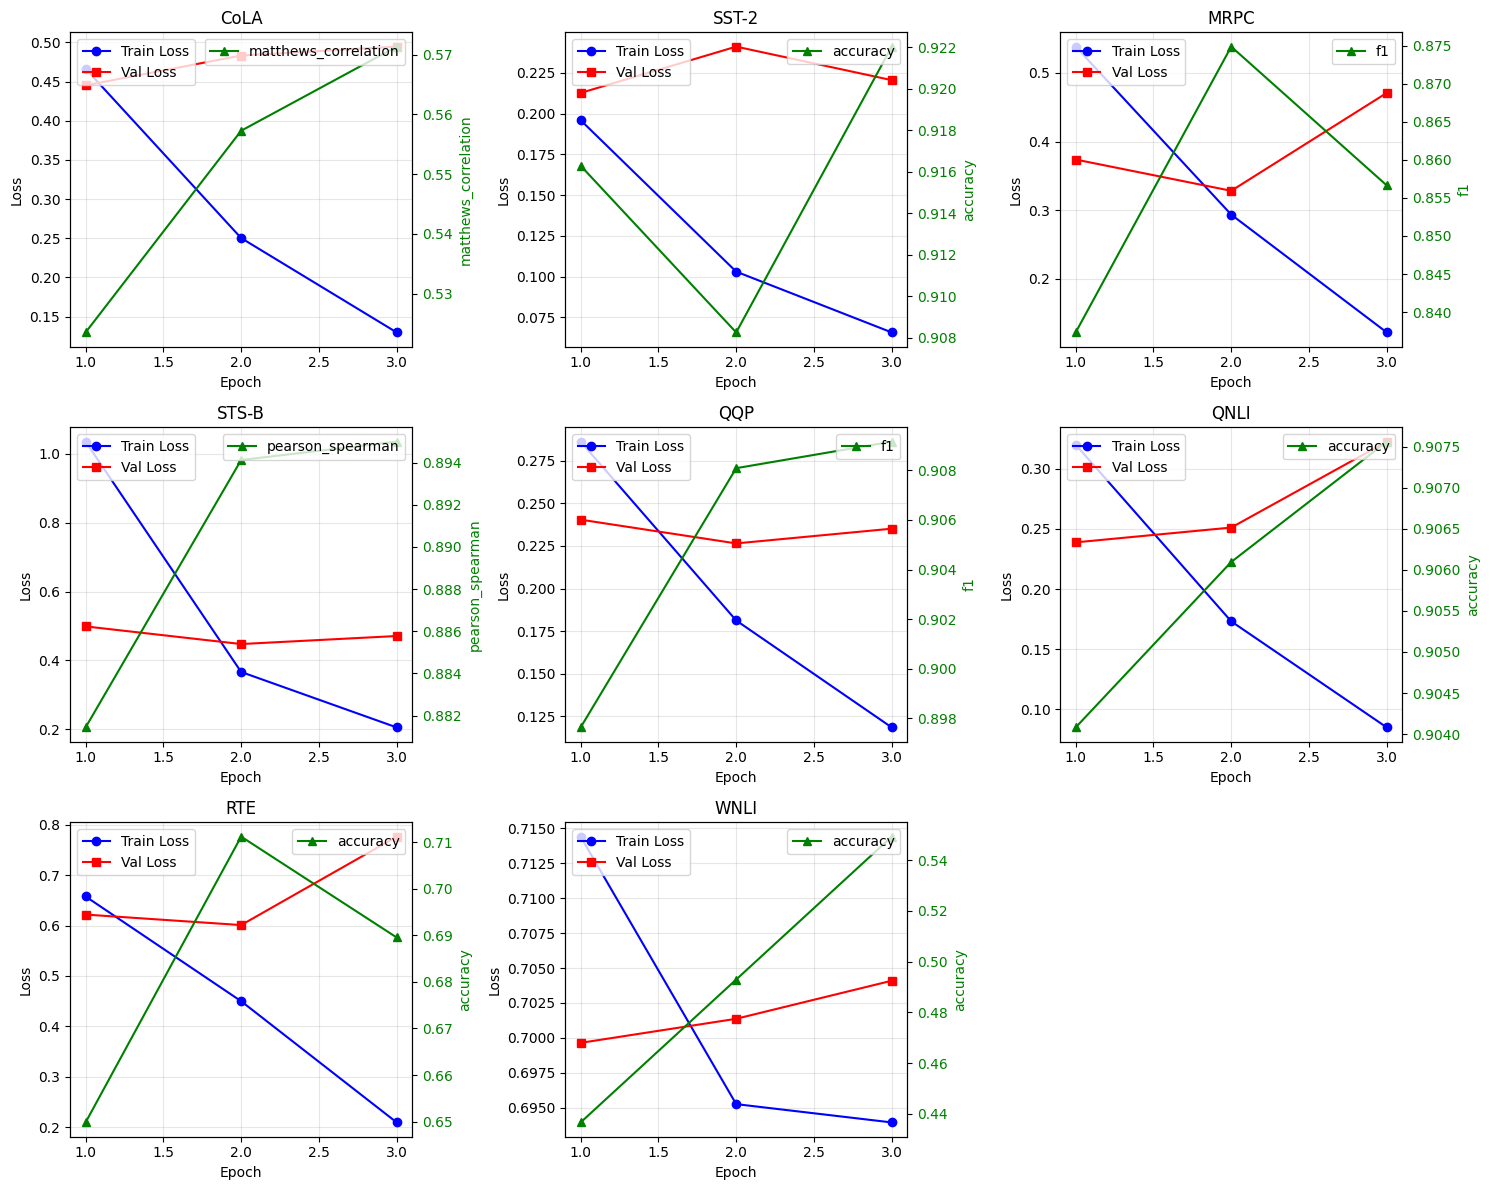

Training curves saved to: glue_training_curves.png


In [7]:
# Cell 6: Plot Training Curves for All Tasks

num_tasks = len(all_histories)
cols = 3
rows = (num_tasks + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
axes = axes.flatten()

for idx, (task_key, history) in enumerate(all_histories.items()):
    ax = axes[idx]
    epochs = range(1, len(history['train_loss']) + 1)

    ax.plot(epochs, history['train_loss'], 'b-', label='Train Loss', marker='o')
    ax.plot(epochs, history['val_loss'], 'r-', label='Val Loss', marker='s')

    ax2 = ax.twinx()
    ax2.plot(epochs, history['val_metric'], 'g-', label=history['metric_name'], marker='^')
    ax2.set_ylabel(history['metric_name'], color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f"{GLUE_TASKS[task_key]['name']}")
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for idx in range(len(all_histories), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('glue_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("Training curves saved to: glue_training_curves.png")


In [8]:
# Cell 7: Print Final Results Summary

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"{'Task':<10} {'Metric':<25} {'Best Score':<15}")
print("-"*60)

for task_key, result in all_results.items():
    print(f"{GLUE_TASKS[task_key]['name']:<10} {result['metric_name']:<25} {result['best_metric']:.4f}")

print("="*60)

# Save results to JSON
with open('glue_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)
print("Results saved to: glue_results.json")



FINAL RESULTS SUMMARY
Task       Metric                    Best Score     
------------------------------------------------------------
CoLA       matthews_correlation      0.5713
SST-2      accuracy                  0.9220
MRPC       f1                        0.8749
STS-B      pearson_spearman          0.8950
QQP        f1                        0.9092
QNLI       accuracy                  0.9076
RTE        accuracy                  0.7112
WNLI       accuracy                  0.5493
Results saved to: glue_results.json


In [9]:
# Cell 8: Generate Predictions for ALL Tasks and Create Submission ZIP

def generate_predictions(task_key, task_config, model, dataset, device, tokenizer, pad_id):
    """Generate predictions for test set"""
    model.eval()
    submission_files = []

    if task_key == "mnli":
        # MNLI has matched and mismatched test sets
        for split_name, split_key in [("matched", "test_matched"), ("mismatched", "test_mismatched")]:
            test_data = load_dataset("glue", "mnli", split=split_key)
            test_collate = functools.partial(collate_test, tokenizer=tokenizer, max_len=TRAIN_CONFIG['max_len'], is_pair=True)
            test_loader = torch.utils.data.DataLoader(test_data, batch_size=TRAIN_CONFIG['batch_size'], shuffle=False, collate_fn=test_collate)

            all_preds = []
            all_indices = [x['idx'] for x in test_data]

            with torch.no_grad():
                for batch in tqdm.tqdm(test_loader, desc=f"MNLI-{split_name}"):
                    input_ids, token_type_ids = batch
                    input_ids, token_type_ids = input_ids.to(device), token_type_ids.to(device)
                    outputs = model(input_ids, token_type_ids, pad_id=pad_id)
                    preds = outputs.argmax(dim=-1).cpu().numpy()
                    all_preds.extend(preds)

            filename = f"MNLI-{'m' if split_name == 'matched' else 'mm'}.tsv"
            with open(filename, 'w', newline='', encoding='utf-8') as f:
                writer = csv.writer(f, delimiter='\t')
                writer.writerow(['index', 'prediction'])
                for idx, pred in zip(all_indices, all_preds):
                    writer.writerow([idx, pred])
            submission_files.append(filename)
    else:
        if 'test' not in dataset:
            return []

        test_collate = functools.partial(collate_test, tokenizer=tokenizer, max_len=TRAIN_CONFIG['max_len'], is_pair=task_config['is_pair'])
        test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=TRAIN_CONFIG['batch_size'], shuffle=False, collate_fn=test_collate)

        all_preds = []
        all_indices = [x['idx'] for x in dataset['test']]

        with torch.no_grad():
            for batch in tqdm.tqdm(test_loader, desc=task_config['name']):
                if task_config['is_pair']:
                    input_ids, token_type_ids = batch
                    input_ids, token_type_ids = input_ids.to(device), token_type_ids.to(device)
                    outputs = model(input_ids, token_type_ids, pad_id=pad_id)
                else:
                    input_ids = batch
                    input_ids = input_ids.to(device)
                    outputs = model(input_ids, pad_id=pad_id)

                if task_config['is_regression']:
                    preds = outputs.squeeze(-1).cpu().numpy()
                    preds = np.clip(preds, 0.0, 5.0)
                    preds = np.round(preds, decimals=1)
                else:
                    preds = outputs.argmax(dim=-1).cpu().numpy()
                all_preds.extend(preds)

        # Proper file naming
                name_map = {"sst2": "SST-2", "stsb": "STS-B", "cola": "CoLA", "mrpc": "MRPC", "qqp": "QQP", "mnli": "MNLI", "qnli": "QNLI", "rte": "RTE", "wnli": "WNLI"}

        with open(filename, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f, delimiter='\t')
            writer.writerow(['index', 'prediction'])
            for idx, pred in zip(all_indices, all_preds):
                writer.writerow([idx, pred])
        submission_files.append(filename)

    return submission_files

print("\n" + "="*60)
print("GENERATING PREDICTIONS FOR ALL TASKS")
print("="*60)

all_submission_files = []

for task_key in all_models:
    print(f"\nProcessing {GLUE_TASKS[task_key]['name']}...")
    files = generate_predictions(task_key, GLUE_TASKS[task_key], all_models[task_key], all_datasets[task_key], device, tokenizer, pad_id)
    all_submission_files.extend(files)
    for f in files:
        print(f"  ✓ Created {f}")

# Generate AX predictions using MNLI model
if 'mnli' in all_models:
    print("\nProcessing AX (using MNLI model)...")
    ax_data = load_dataset("glue", "ax", split="test")
    test_collate = functools.partial(collate_test, tokenizer=tokenizer, max_len=TRAIN_CONFIG['max_len'], is_pair=True)
    test_loader = torch.utils.data.DataLoader(ax_data, batch_size=TRAIN_CONFIG['batch_size'], shuffle=False, collate_fn=test_collate)

    model = all_models['mnli']
    model.eval()
    all_preds = []
    all_indices = [x['idx'] for x in ax_data]

    with torch.no_grad():
        for batch in tqdm.tqdm(test_loader, desc="AX"):
            input_ids, token_type_ids = batch
            input_ids, token_type_ids = input_ids.to(device), token_type_ids.to(device)
            outputs = model(input_ids, token_type_ids, pad_id=pad_id)
            preds = outputs.argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds)

    with open('AX.tsv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerow(['index', 'prediction'])
        for idx, pred in zip(all_indices, all_preds):
            writer.writerow([idx, pred])
    all_submission_files.append('AX.tsv')
    print("  ✓ Created AX.tsv")

print(f"\n{'='*60}")
print("CREATING FINAL SUBMISSION ZIP")
print(f"{'='*60}")

# Create final ZIP
zip_file = "GLUE_submission.zip"
with zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED) as zf:
    for f in all_submission_files:
        if os.path.exists(f):
            zf.write(f, os.path.basename(f))
            print(f"  Added: {f}")

print(f"\n✓ Final submission ZIP created: {zip_file}")
print(f"  Size: {os.path.getsize(zip_file) / 1024:.2f} KB")
print(f"  Contains {len(all_submission_files)} files")
print(f"\n{'='*60}")
print("ALL DONE! You can now submit GLUE_submission.zip to the GLUE leaderboard.")
print(f"{'='*60}")



GENERATING PREDICTIONS FOR ALL TASKS

Processing CoLA...


CoLA: 100%|██████████| 67/67 [00:03<00:00, 17.97it/s]


  ✓ Created CoLA.tsv

Processing SST-2...


SST-2: 100%|██████████| 114/114 [00:06<00:00, 17.02it/s]


  ✓ Created SST-2.tsv

Processing MRPC...


MRPC: 100%|██████████| 108/108 [00:06<00:00, 16.59it/s]


  ✓ Created MRPC.tsv

Processing STS-B...


STS-B: 100%|██████████| 87/87 [00:05<00:00, 17.04it/s]


  ✓ Created STS-B.tsv

Processing QQP...


QQP:   6%|▌         | 1402/24436 [01:21<21:55, 17.51it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
QQP: 100%|██████████| 24436/24436 [23:42<00:00, 17.17it/s]


  ✓ Created QQP.tsv

Processing QNLI...


QNLI:  15%|█▍        | 50/342 [00:02<00:17, 16.66it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
QNLI:  20%|█▉        | 68/342 [00:04<00:16, 16.64it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have be

  ✓ Created QNLI.tsv

Processing RTE...


RTE:  80%|███████▉  | 150/188 [00:08<00:02, 16.70it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not retur

  ✓ Created RTE.tsv

Processing WNLI...


WNLI: 100%|██████████| 10/10 [00:00<00:00, 18.46it/s]


  ✓ Created WNLI.tsv

CREATING FINAL SUBMISSION ZIP
  Added: CoLA.tsv
  Added: SST-2.tsv
  Added: MRPC.tsv
  Added: STS-B.tsv
  Added: QQP.tsv
  Added: QNLI.tsv
  Added: RTE.tsv
  Added: WNLI.tsv

✓ Final submission ZIP created: GLUE_submission.zip
  Size: 936.59 KB
  Contains 8 files

ALL DONE! You can now submit GLUE_submission.zip to the GLUE leaderboard.


In [7]:
# Cell 8: Generate Predictions for ALL Tasks and Create Submission ZIP
# This cell loads models from saved .pth files, so it works after notebook restart!

print("="*60)
print("GENERATING PREDICTIONS FOR ALL TASKS")
print("(Loading models from saved .pth files)")
print("="*60)

# Load tokenizer if not already loaded
if 'tokenizer' not in dir() or tokenizer is None:
    print("\nLoading tokenizer...")
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    pad_id = tokenizer.pad_token_id
    print("  ✓ Tokenizer loaded")

# File naming mapping
name_map = {"sst2": "SST-2", "stsb": "STS-B", "cola": "CoLA", "mrpc": "MRPC",
            "qqp": "QQP", "mnli": "MNLI", "qnli": "QNLI", "rte": "RTE", "wnli": "WNLI"}

def load_model_for_task(task_key, task_config, device):
    """Load a trained model from .pth file"""
    config = BertConfig()

    if task_config['is_regression']:
        model = BertForSequenceRegressionPair(config)
    elif task_config['is_pair']:
        model = BertForSequenceClassificationPair(config, task_config['num_labels'])
    else:
        model = BertForSequenceClassification(config, task_config['num_labels'])

    model_path = f"bert_model_glue_{task_key}.pth"
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        model = model.to(device)
        print(f"  ✓ Loaded model from {model_path}")
        return model
    else:
        print(f"  ✗ Model file not found: {model_path}")
        return None

def generate_predictions_from_file(task_key, task_config, device, tokenizer, pad_id):
    """Generate predictions by loading model from file"""
    submission_files = []

    # Load model
    model = load_model_for_task(task_key, task_config, device)
    if model is None:
        return []

    model.eval()

    if task_key == "mnli":
        # MNLI has matched and mismatched test sets
        for split_name, split_key in [("matched", "test_matched"), ("mismatched", "test_mismatched")]:
            test_data = load_dataset("glue", "mnli", split=split_key)
            test_collate = functools.partial(collate_test, tokenizer=tokenizer, max_len=TRAIN_CONFIG['max_len'], is_pair=True)
            test_loader = torch.utils.data.DataLoader(test_data, batch_size=TRAIN_CONFIG['batch_size'], shuffle=False, collate_fn=test_collate)

            all_preds = []
            all_indices = [x['idx'] for x in test_data]

            with torch.no_grad():
                for batch in tqdm.tqdm(test_loader, desc=f"MNLI-{split_name}"):
                    input_ids, token_type_ids = batch
                    input_ids, token_type_ids = input_ids.to(device), token_type_ids.to(device)
                    outputs = model(input_ids, token_type_ids, pad_id=pad_id)
                    preds = outputs.argmax(dim=-1).cpu().numpy()
                    all_preds.extend(preds)

            filename = f"MNLI-{'m' if split_name == 'matched' else 'mm'}.tsv"
            with open(filename, 'w', newline='', encoding='utf-8') as f:
                writer = csv.writer(f, delimiter='\t')
                writer.writerow(['index', 'prediction'])
                for idx, pred in zip(all_indices, all_preds):
                    writer.writerow([idx, pred])
            submission_files.append(filename)
            print(f"    ✓ Created {filename} ({len(all_preds)} predictions)")
    else:
        # Load test dataset
        dataset = load_dataset("glue", task_key)
        if 'test' not in dataset:
            print(f"    ✗ No test split found for {task_key}")
            return []

        test_collate = functools.partial(collate_test, tokenizer=tokenizer, max_len=TRAIN_CONFIG['max_len'], is_pair=task_config['is_pair'])
        test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=TRAIN_CONFIG['batch_size'], shuffle=False, collate_fn=test_collate)

        all_preds = []
        all_indices = [x['idx'] for x in dataset['test']]

        with torch.no_grad():
            for batch in tqdm.tqdm(test_loader, desc=task_config['name']):
                if task_config['is_pair']:
                    input_ids, token_type_ids = batch
                    input_ids, token_type_ids = input_ids.to(device), token_type_ids.to(device)
                    outputs = model(input_ids, token_type_ids, pad_id=pad_id)
                else:
                    input_ids = batch
                    input_ids = input_ids.to(device)
                    outputs = model(input_ids, pad_id=pad_id)

                if task_config['is_regression']:
                    preds = outputs.squeeze(-1).cpu().numpy()
                    preds = np.clip(preds, 0.0, 5.0)
                    preds = np.round(preds, decimals=1)
                else:
                    preds = outputs.argmax(dim=-1).cpu().numpy()
                all_preds.extend(preds)

        filename = f"{name_map.get(task_key, task_config['name'])}.tsv"
        with open(filename, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f, delimiter='\t')
            writer.writerow(['index', 'prediction'])
            for idx, pred in zip(all_indices, all_preds):
                writer.writerow([idx, pred])
        submission_files.append(filename)
        print(f"    ✓ Created {filename} ({len(all_preds)} predictions)")

    return submission_files

# Check which model files exist
print("\nChecking saved model files...")
available_tasks = []
for task_key in GLUE_TASKS:
    model_path = f"bert_model_glue_{task_key}.pth"
    if os.path.exists(model_path):
        available_tasks.append(task_key)
        print(f"  ✓ {model_path}")
    else:
        print(f"  ✗ {model_path} (not found)")

print(f"\nFound {len(available_tasks)}/{len(GLUE_TASKS)} trained models")

# Generate predictions for all available tasks
all_submission_files = []

for task_key in available_tasks:
    print(f"\n[{available_tasks.index(task_key)+1}/{len(available_tasks)}] Processing {GLUE_TASKS[task_key]['name']}...")
    files = generate_predictions_from_file(task_key, GLUE_TASKS[task_key], device, tokenizer, pad_id)
    all_submission_files.extend(files)

# Generate AX predictions using MNLI model
if 'mnli' in available_tasks:
    print(f"\n[AX] Generating AX predictions (using MNLI model)...")
    mnli_model = load_model_for_task('mnli', GLUE_TASKS['mnli'], device)
    if mnli_model is not None:
        mnli_model.eval()
        ax_data = load_dataset("glue", "ax", split="test")
        test_collate = functools.partial(collate_test, tokenizer=tokenizer, max_len=TRAIN_CONFIG['max_len'], is_pair=True)
        test_loader = torch.utils.data.DataLoader(ax_data, batch_size=TRAIN_CONFIG['batch_size'], shuffle=False, collate_fn=test_collate)

        all_preds = []
        all_indices = [x['idx'] for x in ax_data]

        with torch.no_grad():
            for batch in tqdm.tqdm(test_loader, desc="AX"):
                input_ids, token_type_ids = batch
                input_ids, token_type_ids = input_ids.to(device), token_type_ids.to(device)
                outputs = mnli_model(input_ids, token_type_ids, pad_id=pad_id)
                preds = outputs.argmax(dim=-1).cpu().numpy()
                all_preds.extend(preds)

        with open('AX.tsv', 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f, delimiter='\t')
            writer.writerow(['index', 'prediction'])
            for idx, pred in zip(all_indices, all_preds):
                writer.writerow([idx, pred])
        all_submission_files.append('AX.tsv')
        print(f"    ✓ Created AX.tsv ({len(all_preds)} predictions)")
else:
    print("\n⚠ MNLI model not found, skipping AX predictions")

# Create final ZIP
print(f"\n{'='*60}")
print("CREATING FINAL SUBMISSION ZIP")
print(f"{'='*60}")

zip_file = "GLUE_submission.zip"
with zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED) as zf:
    for f in all_submission_files:
        if os.path.exists(f):
            zf.write(f, os.path.basename(f))
            print(f"  Added: {f}")

print(f"\n{'='*60}")
print(f"✓ Final submission ZIP created: {zip_file}")
print(f"  Size: {os.path.getsize(zip_file) / 1024:.2f} KB")
print(f"  Contains {len(all_submission_files)} files")

# Check if all 11 required files are present
required_files = ['CoLA.tsv', 'SST-2.tsv', 'MRPC.tsv', 'STS-B.tsv', 'QQP.tsv',
                  'MNLI-m.tsv', 'MNLI-mm.tsv', 'QNLI.tsv', 'RTE.tsv', 'WNLI.tsv', 'AX.tsv']
missing = [f for f in required_files if f not in all_submission_files]
if missing:
    print(f"\n⚠ Missing files for complete submission: {missing}")
else:
    print(f"\n✓ All 11 required files are present!")

print(f"{'='*60}")
print("You can now submit GLUE_submission.zip to the GLUE leaderboard.")
print(f"{'='*60}")

GENERATING PREDICTIONS FOR ALL TASKS
(Loading models from saved .pth files)

Checking saved model files...
  ✓ bert_model_glue_cola.pth
  ✓ bert_model_glue_sst2.pth
  ✓ bert_model_glue_mrpc.pth
  ✓ bert_model_glue_stsb.pth
  ✓ bert_model_glue_qqp.pth
  ✓ bert_model_glue_mnli.pth
  ✓ bert_model_glue_qnli.pth
  ✓ bert_model_glue_rte.pth
  ✓ bert_model_glue_wnli.pth

Found 9/9 trained models

[1/9] Processing CoLA...
  ✓ Loaded model from bert_model_glue_cola.pth


cola/train-00000-of-00001.parquet:   0%|          | 0.00/251k [00:00<?, ?B/s]

cola/validation-00000-of-00001.parquet:   0%|          | 0.00/37.6k [00:00<?, ?B/s]

cola/test-00000-of-00001.parquet:   0%|          | 0.00/37.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

CoLA: 100%|██████████| 67/67 [00:03<00:00, 19.04it/s]


    ✓ Created CoLA.tsv (1063 predictions)

[2/9] Processing SST-2...
  ✓ Loaded model from bert_model_glue_sst2.pth


sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

SST-2: 100%|██████████| 114/114 [00:06<00:00, 18.44it/s]


    ✓ Created SST-2.tsv (1821 predictions)

[3/9] Processing MRPC...
  ✓ Loaded model from bert_model_glue_mrpc.pth


mrpc/train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

mrpc/validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

mrpc/test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

MRPC: 100%|██████████| 108/108 [00:06<00:00, 17.30it/s]


    ✓ Created MRPC.tsv (1725 predictions)

[4/9] Processing STS-B...
  ✓ Loaded model from bert_model_glue_stsb.pth


stsb/train-00000-of-00001.parquet:   0%|          | 0.00/502k [00:00<?, ?B/s]

stsb/validation-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

stsb/test-00000-of-00001.parquet:   0%|          | 0.00/114k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

STS-B: 100%|██████████| 87/87 [00:04<00:00, 18.53it/s]


    ✓ Created STS-B.tsv (1379 predictions)

[5/9] Processing QQP...
  ✓ Loaded model from bert_model_glue_qqp.pth


qqp/train-00000-of-00001.parquet:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

qqp/validation-00000-of-00001.parquet:   0%|          | 0.00/3.73M [00:00<?, ?B/s]

qqp/test-00000-of-00001.parquet:   0%|          | 0.00/36.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/363846 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/40430 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/390965 [00:00<?, ? examples/s]

QQP:   6%|▌         | 1402/24436 [01:17<21:34, 17.80it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
QQP: 100%|██████████| 24436/24436 [23:12<00:00, 17.55it/s]


    ✓ Created QQP.tsv (390965 predictions)

[6/9] Processing MNLI...
  ✓ Loaded model from bert_model_glue_mnli.pth


MNLI-matched:  37%|███▋      | 228/613 [00:13<00:22, 17.11it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
MNLI-matched: 100%|██████████| 613/613 [00:35<00:00, 17.13it/s]


    ✓ Created MNLI-m.tsv (9796 predictions)


MNLI-mismatched: 100%|██████████| 616/616 [00:36<00:00, 17.08it/s]


    ✓ Created MNLI-mm.tsv (9847 predictions)

[7/9] Processing QNLI...
  ✓ Loaded model from bert_model_glue_qnli.pth


qnli/train-00000-of-00001.parquet:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

qnli/validation-00000-of-00001.parquet:   0%|          | 0.00/872k [00:00<?, ?B/s]

qnli/test-00000-of-00001.parquet:   0%|          | 0.00/877k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/104743 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5463 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5463 [00:00<?, ? examples/s]

QNLI:  15%|█▍        | 50/342 [00:02<00:17, 16.96it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
QNLI:  20%|█▉        | 68/342 [00:04<00:16, 16.93it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have be

    ✓ Created QNLI.tsv (5463 predictions)

[8/9] Processing RTE...
  ✓ Loaded model from bert_model_glue_rte.pth


rte/train-00000-of-00001.parquet:   0%|          | 0.00/584k [00:00<?, ?B/s]

rte/validation-00000-of-00001.parquet:   0%|          | 0.00/69.0k [00:00<?, ?B/s]

rte/test-00000-of-00001.parquet:   0%|          | 0.00/621k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

RTE:  80%|███████▉  | 150/188 [00:08<00:02, 17.23it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not retur

    ✓ Created RTE.tsv (3000 predictions)

[9/9] Processing WNLI...
  ✓ Loaded model from bert_model_glue_wnli.pth


wnli/train-00000-of-00001.parquet:   0%|          | 0.00/38.8k [00:00<?, ?B/s]

wnli/validation-00000-of-00001.parquet:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

wnli/test-00000-of-00001.parquet:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/635 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/71 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/146 [00:00<?, ? examples/s]

WNLI: 100%|██████████| 10/10 [00:00<00:00, 18.05it/s]


    ✓ Created WNLI.tsv (146 predictions)

[AX] Generating AX predictions (using MNLI model)...
  ✓ Loaded model from bert_model_glue_mnli.pth


ax/test-00000-of-00001.parquet:   0%|          | 0.00/80.8k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1104 [00:00<?, ? examples/s]

AX: 100%|██████████| 69/69 [00:03<00:00, 17.64it/s]


    ✓ Created AX.tsv (1104 predictions)

CREATING FINAL SUBMISSION ZIP
  Added: CoLA.tsv
  Added: SST-2.tsv
  Added: MRPC.tsv
  Added: STS-B.tsv
  Added: QQP.tsv
  Added: MNLI-m.tsv
  Added: MNLI-mm.tsv
  Added: QNLI.tsv
  Added: RTE.tsv
  Added: WNLI.tsv
  Added: AX.tsv

✓ Final submission ZIP created: GLUE_submission.zip
  Size: 986.46 KB
  Contains 11 files

✓ All 11 required files are present!
You can now submit GLUE_submission.zip to the GLUE leaderboard.
